In [42]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

def normalisation(X):
    minX = np.min(X)
    maxX = np.max(X)

    return (X - minX)/(maxX - minX)

class CustomDataset(Dataset):
    def __init__(self, clean_data, noisy_data):
        self.clean = clean_data
        self.noisy = noisy_data

    def __len__(self):
        return len(self.clean)

    def __getitem__(self, index):
        clean_tensor = torch.from_numpy(normalisation(self.clean[index, :])).to(torch.float32)
        noisy_tensor = torch.from_numpy(normalisation(self.noisy[index, :])).to(torch.float32)

        return clean_tensor, noisy_tensor

In [55]:
class config:
    batch_size=10
    learning_rate=1e-3
    epochs=30

In [102]:
clean = pd.read_csv('label1f.csv').to_numpy()
noisy = pd.read_csv('train1f.csv').to_numpy()

test_clean = clean[:10]
test_noisy = noisy[:10]

training_dataset = CustomDataset(clean[10:900], noisy[10:900])
validation_dataset = CustomDataset(clean[900:990], noisy[900:990])

trainloader = DataLoader(training_dataset, batch_size=config.batch_size)
validloader = DataLoader(validation_dataset, batch_size=config.batch_size)

In [105]:
import torch
import torch.nn as nn

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_1 = nn.Conv1d(in_channels=config.batch_size, out_channels=128, kernel_size=3, padding=1)
        self.encoder_2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.encoder_3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.encoder_4 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.encoder_5 = nn.Conv1d(in_channels=16, out_channels=8, kernel_size=3, padding=1)

        self.decoder_1 = nn.ConvTranspose1d(in_channels=8, out_channels=8, kernel_size=3, padding = 1)
        self.decoder_2 = nn.ConvTranspose1d(in_channels=8, out_channels=16, kernel_size=3, padding = 1)
        self.decoder_3 = nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=3, padding = 1)
        self.decoder_4 = nn.ConvTranspose1d(in_channels=32, out_channels=64, kernel_size=3, padding = 1)
        self.decoder_5 = nn.ConvTranspose1d(in_channels=64, out_channels=128, kernel_size=3, padding = 1)
        self.decoder_6 = nn.ConvTranspose1d(in_channels=128, out_channels=config.batch_size, padding=1, kernel_size=3)

    def forward(self, features):
        en1 = torch.relu(self.encoder_1(features))
        en2 = torch.relu(self.encoder_2(en1))
        en3 = torch.relu(self.encoder_3(en2))
        en4 = torch.relu(self.encoder_4(en3))
        en5 = torch.relu(self.encoder_5(en4))
        de1 = torch.relu(self.decoder_1(en5))
        de2 = torch.relu(self.decoder_2(de1))
        de3 = torch.relu(self.decoder_3(de2))
        de4 = torch.relu(self.decoder_4(de3))
        de5 = torch.relu(self.decoder_5(de4))
        de6 = torch.sigmoid(self.decoder_6(de5))
        return de6

In [107]:
from torchsummary import summary

model = AE()

summary(model, (10, 4096))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 128, 4096]           3,968
            Conv1d-2             [-1, 64, 4096]          24,640
            Conv1d-3             [-1, 32, 4096]           6,176
            Conv1d-4             [-1, 16, 4096]           1,552
            Conv1d-5              [-1, 8, 4096]             392
   ConvTranspose1d-6              [-1, 8, 4096]             200
   ConvTranspose1d-7             [-1, 16, 4096]             400
   ConvTranspose1d-8             [-1, 32, 4096]           1,568
   ConvTranspose1d-9             [-1, 64, 4096]           6,208
  ConvTranspose1d-10            [-1, 128, 4096]          24,704
  ConvTranspose1d-11             [-1, 10, 4096]           3,850
Total params: 73,658
Trainable params: 73,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.16
Forward/ba

In [108]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def trainA(dataloader, model, epoch, loss_fn, optimizer, device):
    model.train()
    total_loss = 0.0
    for i, (clean, noisy) in enumerate(tqdm(dataloader)):
        clean = clean.to(device)
        noisy = noisy.to(device)

        optimizer.zero_grad()
        pred = model(noisy)
        curr_loss = loss_fn(pred, clean)
        curr_loss.backward()
        optimizer.step()



        total_loss += curr_loss
        if (i+1) % 40 == 0:
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, total_loss/(i+1)))

    print('[Epoch number : %d] loss: %.3f' % (epoch + 1, total_loss/89))

def valA(dataloader, model, epoch, loss_fn, device):
    model.eval()
    total_loss = 0.0
    print('-------------------------')
    with torch.no_grad():
        for i, (clean, noisy) in enumerate(tqdm(dataloader)):
            clean = clean.to(device)
            noisy = noisy.to(device)

            output = model(noisy)
            loss = loss_fn(output, clean)
            total_loss += loss

            pred1D = output.cpu().detach().numpy().reshape(10, 4096)
            clean1D= clean.cpu().detach().numpy().reshape(10, 4096)

            if i%4 == 0:
                plt.figure()
                plt.plot(np.arange(0, 4096, 1), pred1D[1])
                plt.plot(np.arange(0, 4096, 1), clean1D[1])
                plt.xlim([0, 200])
                plt.show()

        print('[Validation] loss: %.3f' %
              (total_loss / 90))

-------------------| EPOCH 0 |-------------------


 46%|████▌     | 41/89 [00:06<00:06,  7.98it/s]

[Epoch number : 1, Mini-batches:    40] loss: 0.125


 91%|█████████ | 81/89 [00:12<00:01,  6.63it/s]

[Epoch number : 1, Mini-batches:    80] loss: 0.122


100%|██████████| 89/89 [00:13<00:00,  6.77it/s]


[Epoch number : 1] loss: 0.122
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

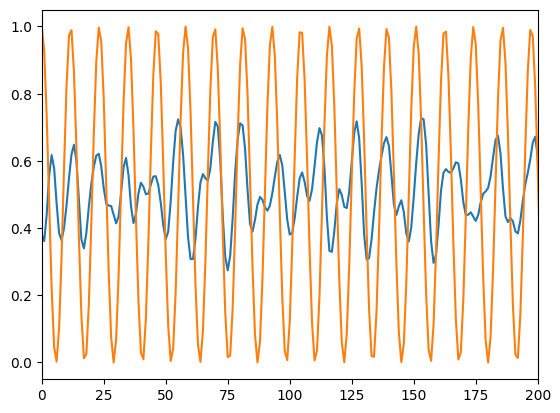

 44%|████▍     | 4/9 [00:00<00:00,  5.61it/s]

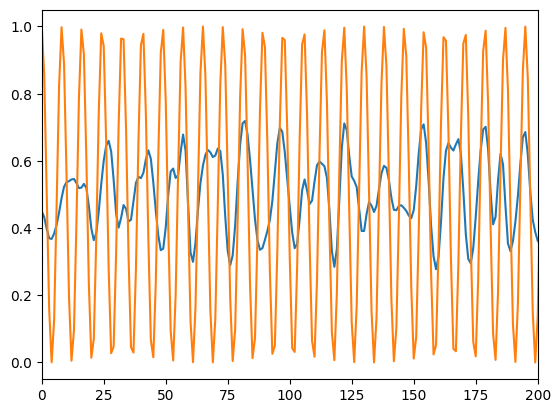

 78%|███████▊  | 7/9 [00:01<00:00,  5.16it/s]

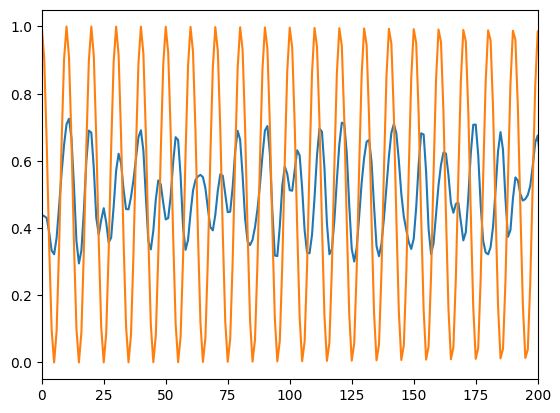

100%|██████████| 9/9 [00:02<00:00,  4.16it/s]


[Validation] loss: 0.012
--------------------------------------------------
-------------------| EPOCH 1 |-------------------


 46%|████▌     | 41/89 [00:06<00:09,  4.98it/s]

[Epoch number : 2, Mini-batches:    40] loss: 0.117


 90%|████████▉ | 80/89 [00:12<00:01,  4.98it/s]

[Epoch number : 2, Mini-batches:    80] loss: 0.116


100%|██████████| 89/89 [00:14<00:00,  6.33it/s]


[Epoch number : 2] loss: 0.116
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

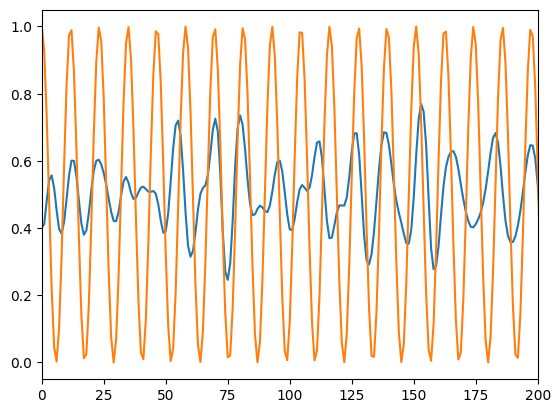

 33%|███▎      | 3/9 [00:00<00:01,  5.15it/s]

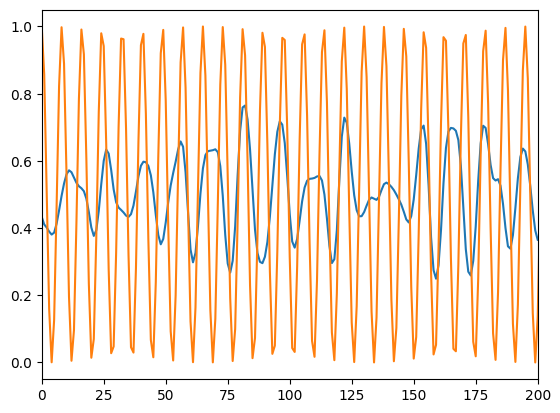

 78%|███████▊  | 7/9 [00:01<00:00,  6.09it/s]

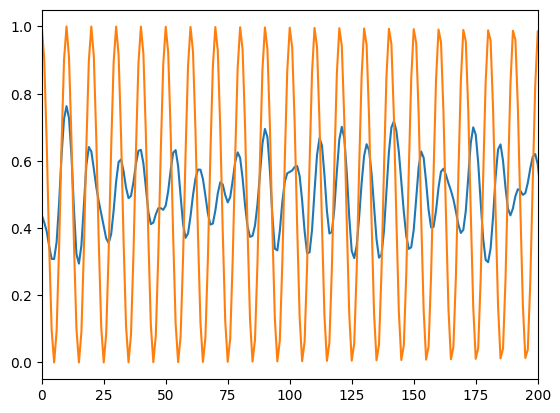

100%|██████████| 9/9 [00:01<00:00,  4.57it/s]


[Validation] loss: 0.012
--------------------------------------------------
-------------------| EPOCH 2 |-------------------


 46%|████▌     | 41/89 [00:07<00:07,  6.72it/s]

[Epoch number : 3, Mini-batches:    40] loss: 0.116


 91%|█████████ | 81/89 [00:14<00:01,  6.37it/s]

[Epoch number : 3, Mini-batches:    80] loss: 0.116


100%|██████████| 89/89 [00:15<00:00,  5.78it/s]


[Epoch number : 3] loss: 0.116
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

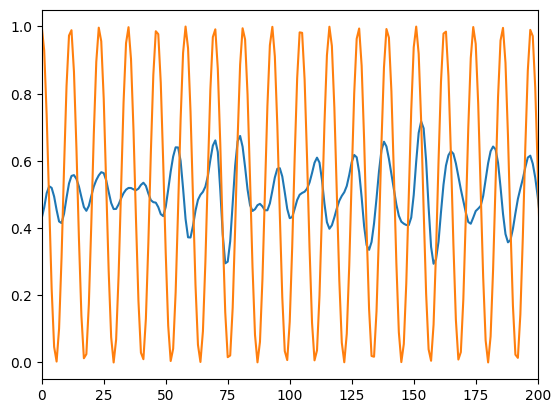

 33%|███▎      | 3/9 [00:00<00:00,  6.43it/s]

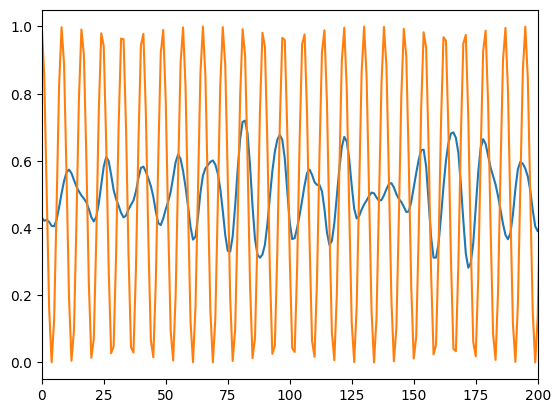

 89%|████████▉ | 8/9 [00:01<00:00,  7.84it/s]

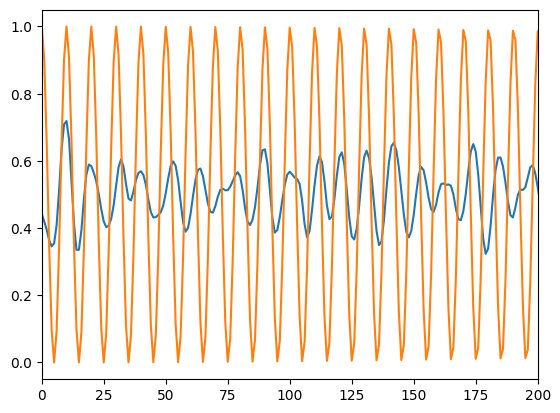

100%|██████████| 9/9 [00:01<00:00,  5.36it/s]


[Validation] loss: 0.012
--------------------------------------------------
-------------------| EPOCH 3 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.40it/s]

[Epoch number : 4, Mini-batches:    40] loss: 0.115


 91%|█████████ | 81/89 [00:12<00:01,  6.27it/s]

[Epoch number : 4, Mini-batches:    80] loss: 0.113


100%|██████████| 89/89 [00:14<00:00,  6.24it/s]


[Epoch number : 4] loss: 0.112
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

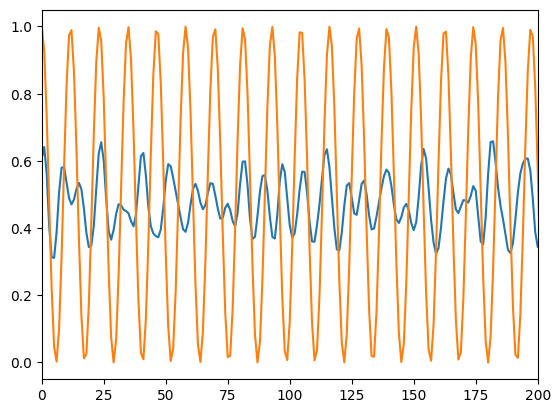

 44%|████▍     | 4/9 [00:00<00:00,  7.72it/s]

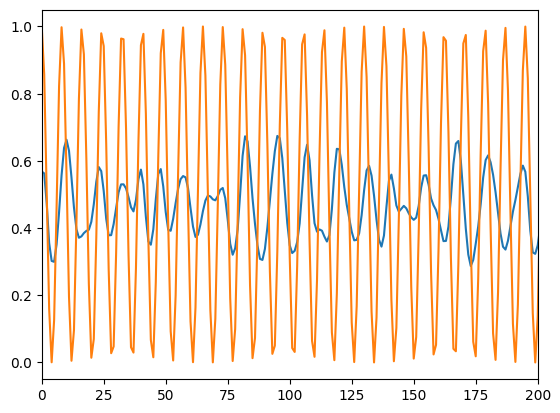

 78%|███████▊  | 7/9 [00:01<00:00,  6.83it/s]

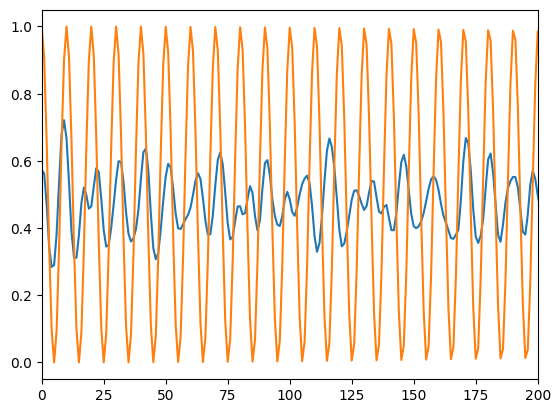

100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


[Validation] loss: 0.011
--------------------------------------------------
-------------------| EPOCH 4 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.81it/s]

[Epoch number : 5, Mini-batches:    40] loss: 0.107


 91%|█████████ | 81/89 [00:12<00:01,  6.65it/s]

[Epoch number : 5, Mini-batches:    80] loss: 0.107


100%|██████████| 89/89 [00:13<00:00,  6.45it/s]


[Epoch number : 5] loss: 0.107
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

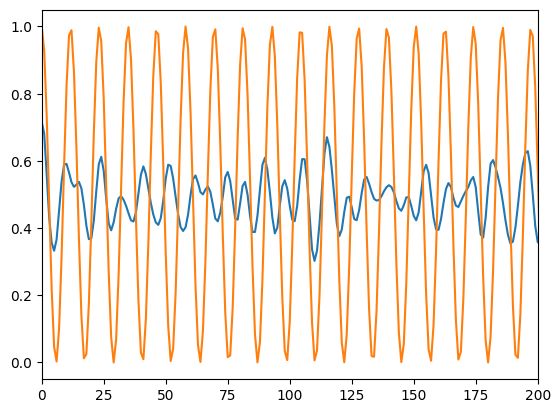

 33%|███▎      | 3/9 [00:00<00:01,  5.96it/s]

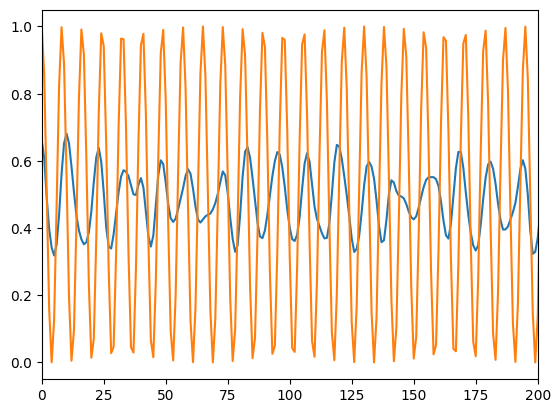

 89%|████████▉ | 8/9 [00:01<00:00,  6.04it/s]

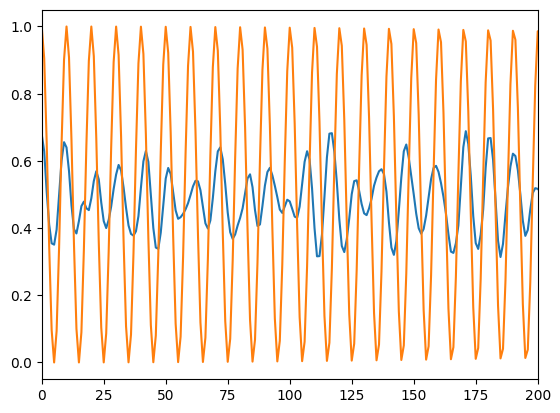

100%|██████████| 9/9 [00:02<00:00,  4.31it/s]


[Validation] loss: 0.011
--------------------------------------------------
-------------------| EPOCH 5 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.26it/s]

[Epoch number : 6, Mini-batches:    40] loss: 0.106


 91%|█████████ | 81/89 [00:12<00:01,  6.52it/s]

[Epoch number : 6, Mini-batches:    80] loss: 0.106


100%|██████████| 89/89 [00:13<00:00,  6.41it/s]


[Epoch number : 6] loss: 0.106
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

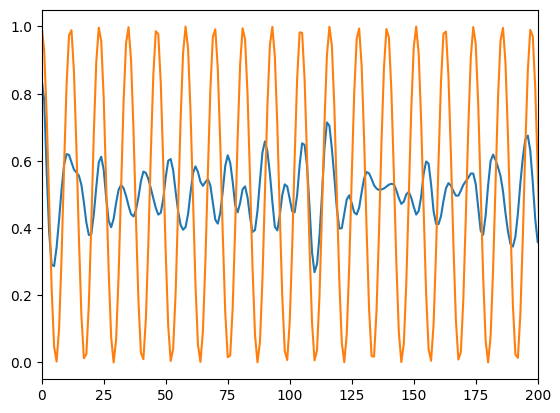

 33%|███▎      | 3/9 [00:00<00:00,  6.45it/s]

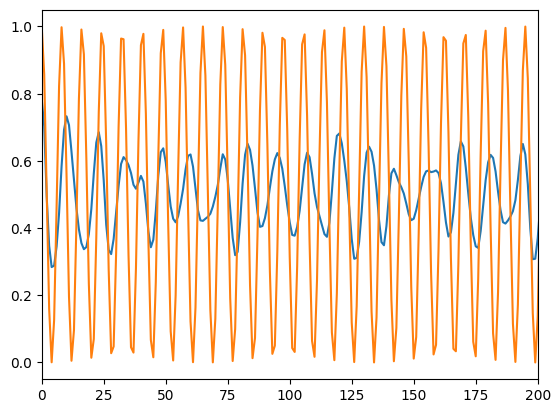

 78%|███████▊  | 7/9 [00:01<00:00,  6.75it/s]

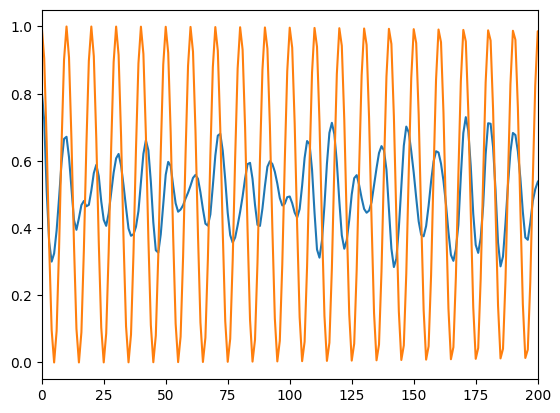

100%|██████████| 9/9 [00:01<00:00,  5.30it/s]


[Validation] loss: 0.011
--------------------------------------------------
-------------------| EPOCH 6 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.20it/s]

[Epoch number : 7, Mini-batches:    40] loss: 0.106


 91%|█████████ | 81/89 [00:12<00:01,  6.96it/s]

[Epoch number : 7, Mini-batches:    80] loss: 0.106


100%|██████████| 89/89 [00:13<00:00,  6.49it/s]


[Epoch number : 7] loss: 0.106
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

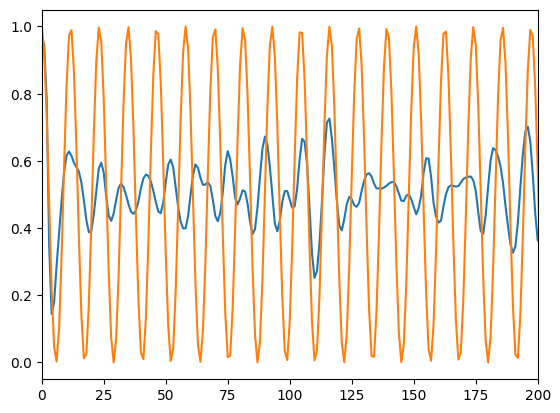

 33%|███▎      | 3/9 [00:00<00:00,  6.24it/s]

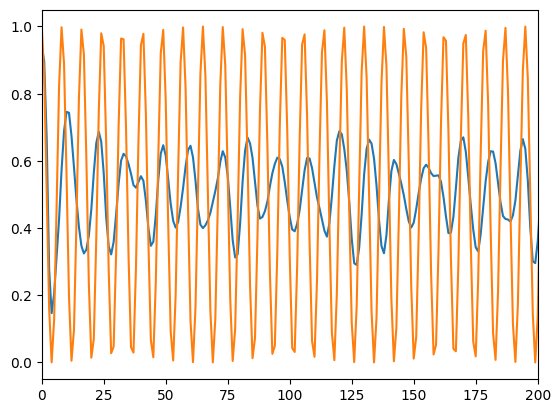

 78%|███████▊  | 7/9 [00:01<00:00,  7.57it/s]

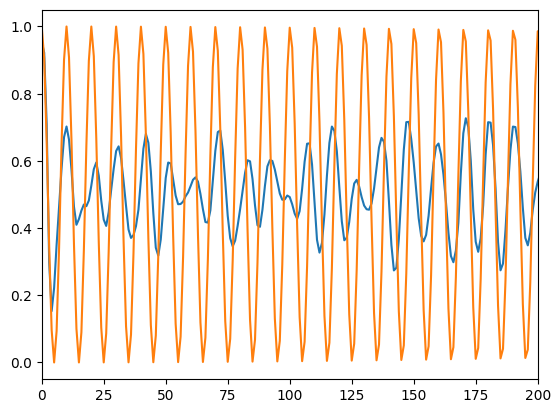

100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 7 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.50it/s]

[Epoch number : 8, Mini-batches:    40] loss: 0.105


 90%|████████▉ | 80/89 [00:12<00:01,  7.00it/s]

[Epoch number : 8, Mini-batches:    80] loss: 0.105


100%|██████████| 89/89 [00:13<00:00,  6.36it/s]


[Epoch number : 8] loss: 0.105
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

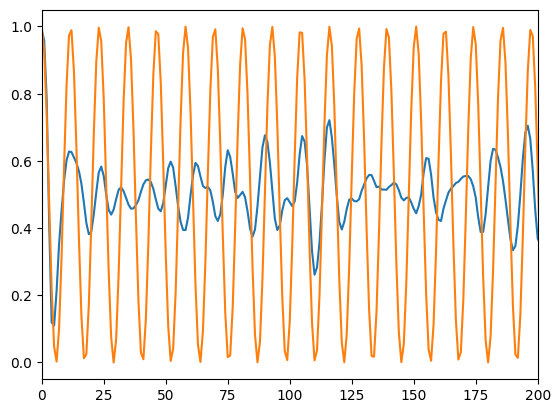

 44%|████▍     | 4/9 [00:00<00:00,  7.17it/s]

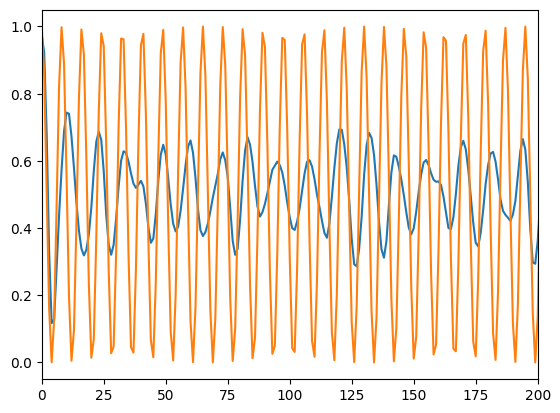

 78%|███████▊  | 7/9 [00:01<00:00,  6.27it/s]

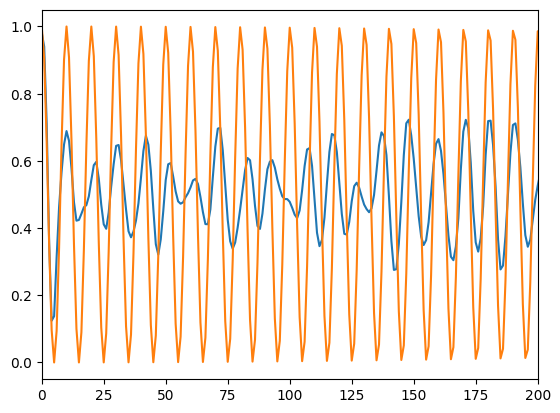

100%|██████████| 9/9 [00:01<00:00,  5.33it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 8 |-------------------


 46%|████▌     | 41/89 [00:06<00:06,  6.88it/s]

[Epoch number : 9, Mini-batches:    40] loss: 0.105


 91%|█████████ | 81/89 [00:12<00:01,  7.21it/s]

[Epoch number : 9, Mini-batches:    80] loss: 0.105


100%|██████████| 89/89 [00:13<00:00,  6.68it/s]


[Epoch number : 9] loss: 0.105
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

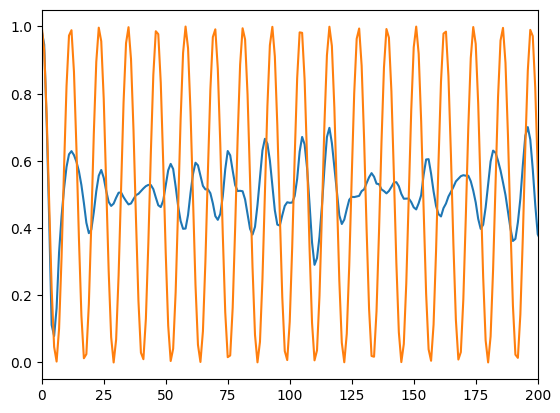

 33%|███▎      | 3/9 [00:00<00:00,  7.29it/s]

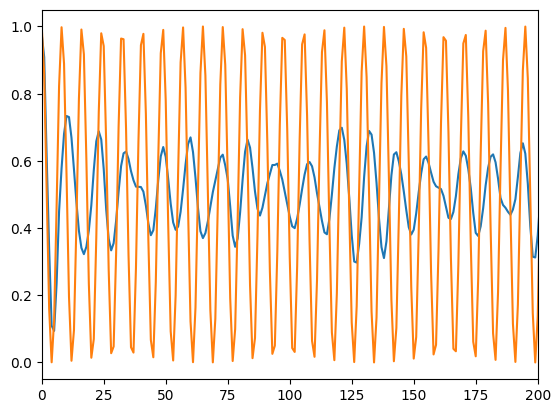

 78%|███████▊  | 7/9 [00:01<00:00,  7.02it/s]

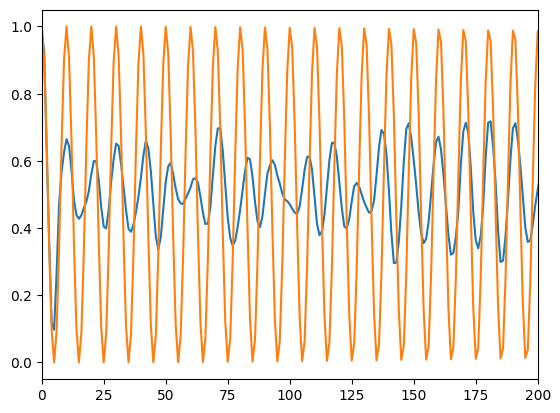

100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 9 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.02it/s]

[Epoch number : 10, Mini-batches:    40] loss: 0.105


 91%|█████████ | 81/89 [00:13<00:01,  6.10it/s]

[Epoch number : 10, Mini-batches:    80] loss: 0.105


100%|██████████| 89/89 [00:14<00:00,  6.02it/s]


[Epoch number : 10] loss: 0.105
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

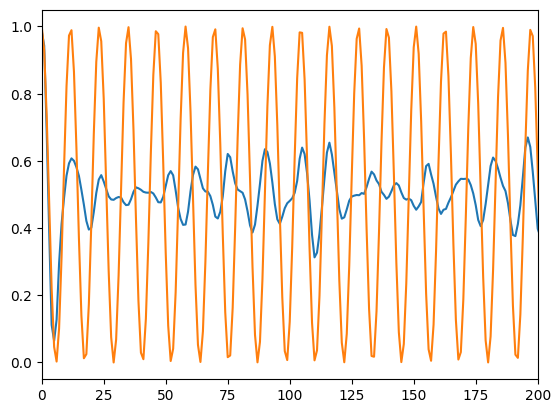

 33%|███▎      | 3/9 [00:00<00:00,  6.21it/s]

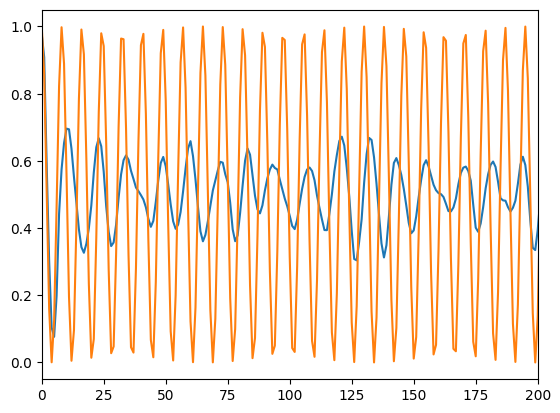

 89%|████████▉ | 8/9 [00:01<00:00,  8.15it/s]

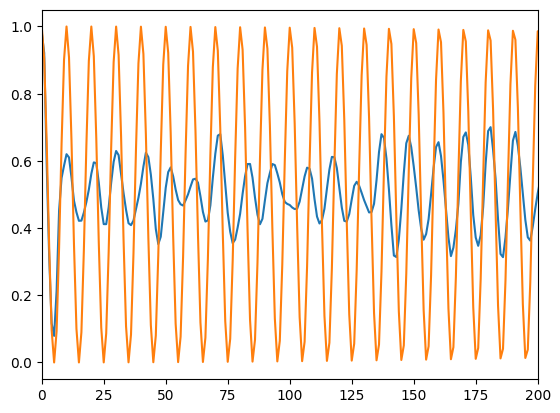

100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 10 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.42it/s]

[Epoch number : 11, Mini-batches:    40] loss: 0.105


 91%|█████████ | 81/89 [00:13<00:01,  6.70it/s]

[Epoch number : 11, Mini-batches:    80] loss: 0.105


100%|██████████| 89/89 [00:15<00:00,  5.83it/s]


[Epoch number : 11] loss: 0.105
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

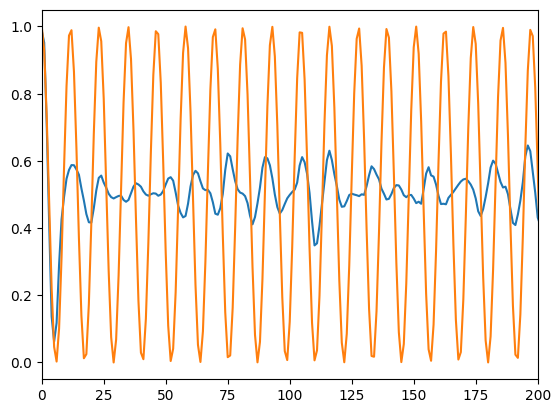

 33%|███▎      | 3/9 [00:00<00:00,  6.09it/s]

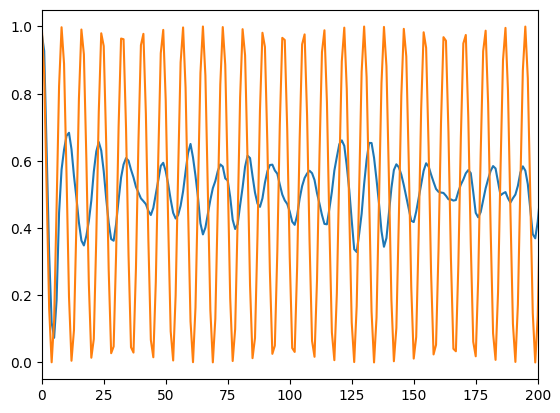

 78%|███████▊  | 7/9 [00:01<00:00,  6.69it/s]

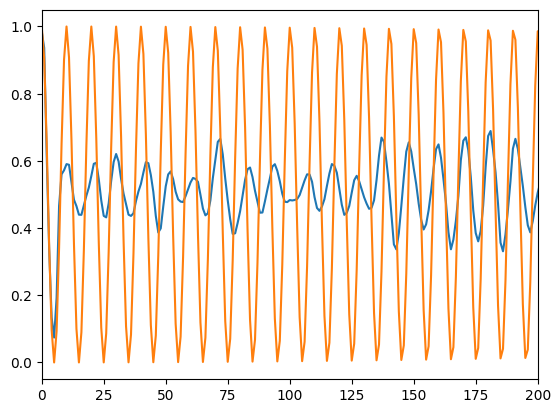

100%|██████████| 9/9 [00:01<00:00,  5.46it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 11 |-------------------


 46%|████▌     | 41/89 [00:06<00:06,  7.16it/s]

[Epoch number : 12, Mini-batches:    40] loss: 0.104


 91%|█████████ | 81/89 [00:11<00:01,  7.96it/s]

[Epoch number : 12, Mini-batches:    80] loss: 0.104


100%|██████████| 89/89 [00:12<00:00,  7.05it/s]


[Epoch number : 12] loss: 0.104
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

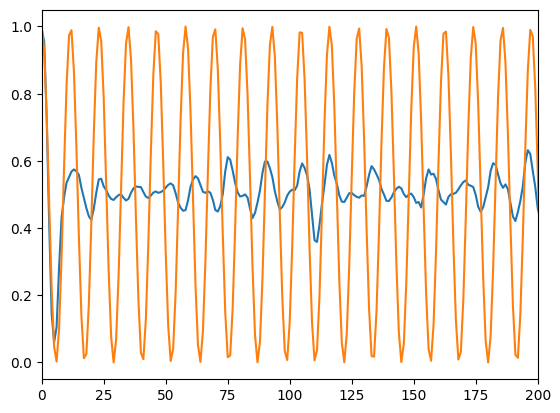

 33%|███▎      | 3/9 [00:00<00:00,  8.15it/s]

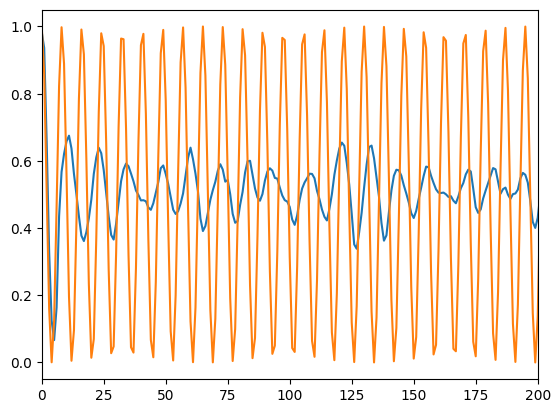

 78%|███████▊  | 7/9 [00:00<00:00,  8.08it/s]

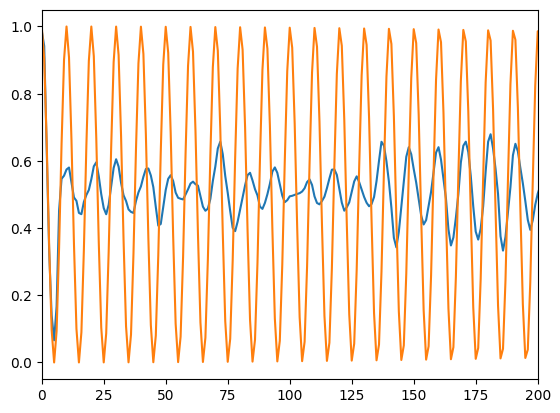

100%|██████████| 9/9 [00:01<00:00,  6.48it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 12 |-------------------


 46%|████▌     | 41/89 [00:06<00:06,  7.68it/s]

[Epoch number : 13, Mini-batches:    40] loss: 0.104


 91%|█████████ | 81/89 [00:12<00:01,  6.43it/s]

[Epoch number : 13, Mini-batches:    80] loss: 0.104


100%|██████████| 89/89 [00:13<00:00,  6.58it/s]


[Epoch number : 13] loss: 0.103
-------------------------


  0%|          | 0/9 [00:00<?, ?it/s]

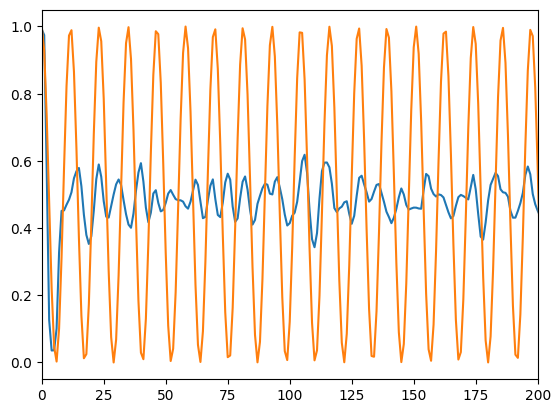

 33%|███▎      | 3/9 [00:00<00:00,  7.08it/s]

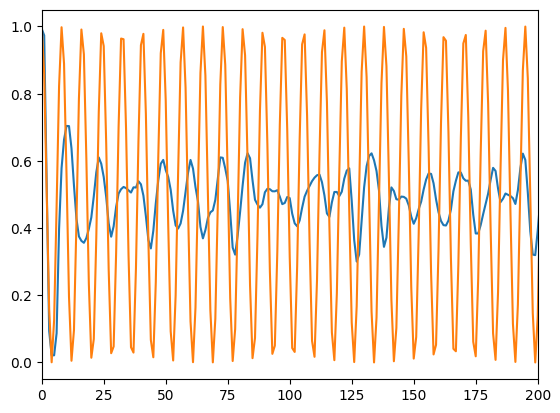

 78%|███████▊  | 7/9 [00:01<00:00,  7.37it/s]

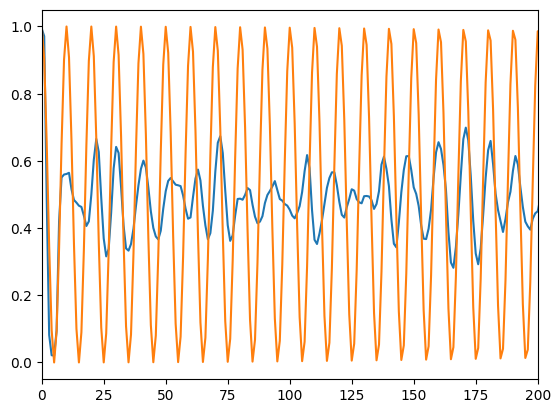

100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


[Validation] loss: 0.010
--------------------------------------------------
-------------------| EPOCH 13 |-------------------


 46%|████▌     | 41/89 [00:06<00:07,  6.01it/s]

[Epoch number : 14, Mini-batches:    40] loss: 0.098


 87%|████████▋ | 77/89 [00:12<00:01,  6.09it/s]


KeyboardInterrupt: 

In [109]:
from torch import optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = AE().to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
loss_fn = torch.nn.functional.mse_loss

for epoch in range(config.epochs):
    print("-------------------| EPOCH %d |-------------------" % epoch)
    trainA(trainloader, model, epoch, loss_fn, optimizer, device)
    valA(validloader, model, epoch, loss_fn, device)
    print("--------------------------------------------------")

(10, 4096)


(0.0, 100.0)

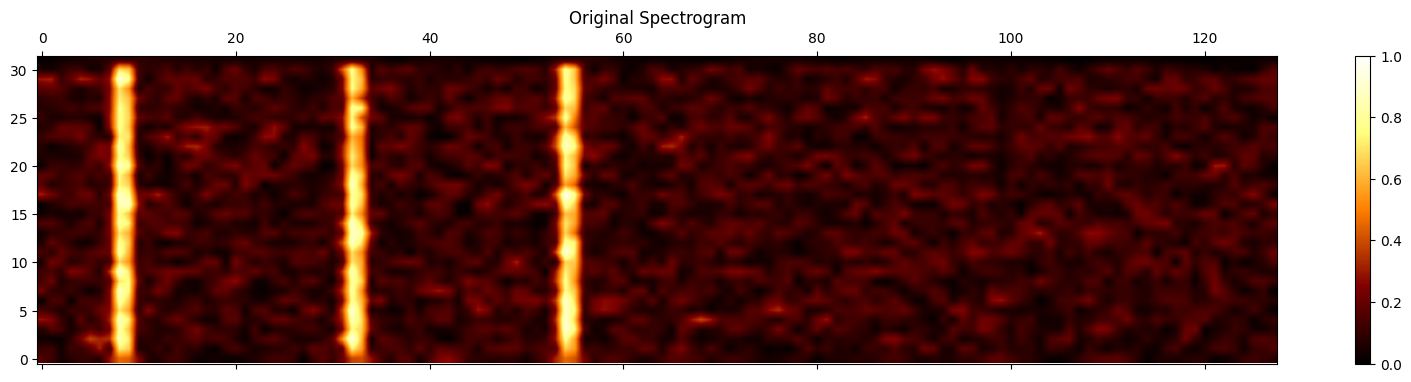

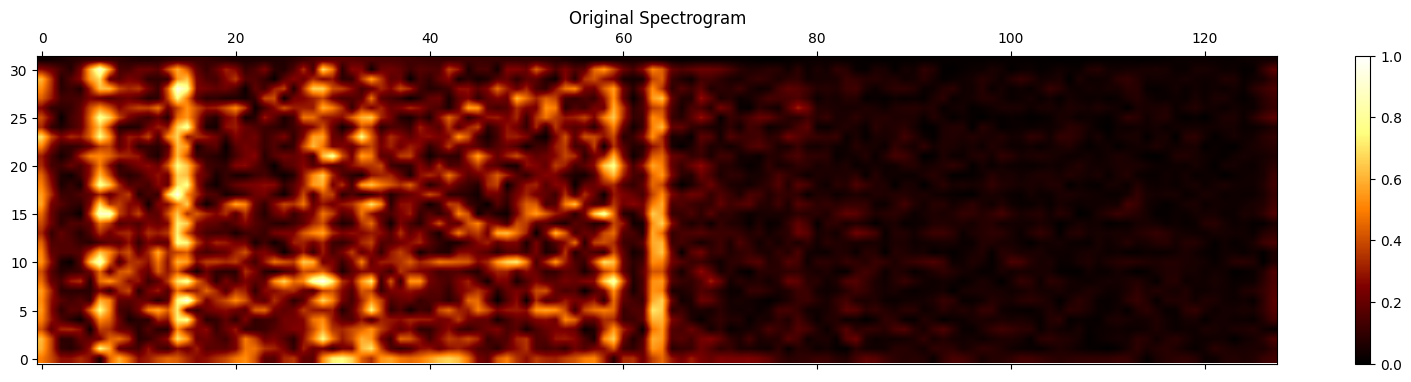

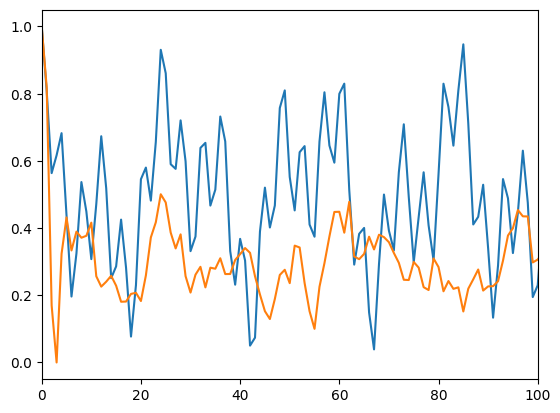

In [95]:
from scipy import signal

s = test_noisy
sc = test_clean

idx_test = 1

print(s.shape)

X = normalisation(np.abs(signal.stft(s[idx_test], nperseg=254, noverlap=120)[2]).reshape((1, 128, 32)))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

res = model.forward(torch.from_numpy(s).to(torch.float32).to(device))

res = res.cpu().detach().numpy().reshape(10, 4096)

res -= np.mean(res)

Xres = normalisation(np.abs(signal.stft(res[idx_test], nperseg=254, noverlap=120)[2]).reshape((1, 128, 32)))

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(Xres), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')

plt.figure()
plt.plot(np.arange(0, 4096, 1), normalisation(sc[0]))
plt.plot(np.arange(0, 4096, 1), normalisation(res[0]))
plt.xlim([0, 100])